In [3]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from pipeline.feature_extraction import FeaturesExtraction
from pathlib import Path
import time
import copy

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

In [4]:
torch.cuda.is_available()

c:\Users\Lenovo\miniconda3\envs\skin_lesion\lib\site-packages\torch\cuda\__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

### Data prep

In [3]:
data = SkinLesion_Dataset(class_task='binary',resize_image= False, process=True)
preproc = SkinLesionPreprocessing(resize=True, remove_hair=False)

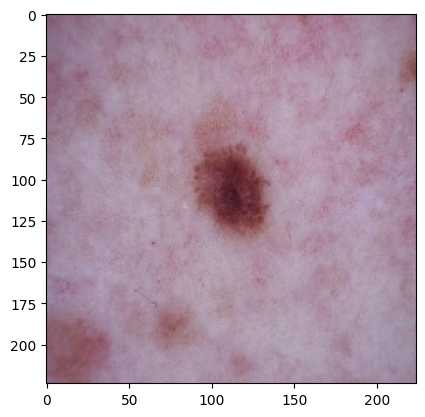

In [4]:
plt.imshow(data[0]['img'])

In [ ]:
# datasets = {
#         'train': SkinLesion_Dataset(class_task='binary', partitions=['train'], 
#                                     process=True, transforms=data_transforms['train']),
#         'val': SkinLesion_Dataset(class_task='binary', partitions=['val'],
#                                   process=True, transforms=data_transforms['val'])
#         }

# def collate_fn(batch):
#         return tuple(zip(*batch))

# dataloaders = {
#         'val': DataLoader(
#             datasets['val'], batch_size=5,
#             num_workers=4, collate_fn=collate_fn, drop_last=False),
#         'train': DataLoader(
#             datasets['train'], batch_size=2,
#             shuffle=True, collate_fn=collate_fn, num_workers=4, drop_last=False)
#     }


In [3]:
exp_name = 'vanilla_pipe/'
cfg = {
    'data': {
        'data_dir' : '../../data_processed/binary/',
        'chkpt_path' : '../../models/binary/' + exp_name,
        'best_model_path' : '../../models/binary/' + exp_name + 'best_model.pt',
        'tensorboard_path' : '../../models/binary/tensorboard/',
        },
    'train': {
        'epochs' : 25,
        'batch_size' : 10,
        'lr' : 0.001,
        'momentum' : 0.9,
        'weight_decay' : 0.0005,
        'num_workers' : 4,
        'lr_step_size' : 7,
        'gamma' : 0.1,
        },
    'val': {
        'batch_size' : 5,
        'num_workers' : 4,
        }
}
       

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms['train'])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # "cpu"


In [5]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=False)
    }

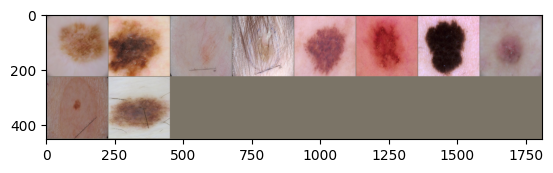

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

### Train model

In [7]:
def train_model(model, criterion, optimizer, scheduler, writer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'acc/{phase}', epoch_acc, epoch+1)
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path'] + f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### finetuning

In [7]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])

In [8]:
writer = SummaryWriter(cfg['data']['tensorboard_path'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/24
----------
train Loss: 0.4575 Acc: 0.7874
val Loss: 0.3625 Acc: 0.8380

Epoch 1/24
----------
train Loss: 0.3836 Acc: 0.8269
val Loss: 0.3426 Acc: 0.8477

Epoch 2/24
----------
train Loss: 0.3278 Acc: 0.8587
val Loss: 0.3242 Acc: 0.8554

Epoch 3/24
----------
train Loss: 0.2884 Acc: 0.8782
val Loss: 0.3542 Acc: 0.8422

Epoch 4/24
----------
train Loss: 0.2480 Acc: 0.8977
val Loss: 0.3585 Acc: 0.8411

Epoch 5/24
----------
train Loss: 0.2151 Acc: 0.9130
val Loss: 0.3713 Acc: 0.8501

Epoch 6/24
----------
train Loss: 0.1921 Acc: 0.9227
val Loss: 0.3538 Acc: 0.8588

Epoch 7/24
----------
train Loss: 0.1174 Acc: 0.9568
val Loss: 0.3249 Acc: 0.8788

Epoch 8/24
----------
train Loss: 0.0968 Acc: 0.9666
val Loss: 0.3259 Acc: 0.8717

Epoch 9/24
----------
train Loss: 0.0794 Acc: 0.9728
val Loss: 0.3439 Acc: 0.8762

Epoch 10/24
----------
train Loss: 0.0764 Acc: 0.9726
val Loss: 0.3363 Acc: 0.8725

Epoch 11/24
----------
train Loss: 0.0669 Acc: 0.9773
val Loss: 0.3364 Acc: 0.8759

Ep

KeyboardInterrupt: 

#### mobilenet

In [9]:
# mobile net
model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_ftrs = model_ft.classifier[1].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

print(model_ft.classifier)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_ft)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)
+-----------------------------+------------+
|           Modules           | Parameters |
+-----------------------------+------------+
|     features.0.0.weight     |    864     |
|     features.0.1.weight     |     32     |
|      features.0.1.bias      |     32     |
|  features.1.conv.0.0.weight |    288     |
|  features.1.conv.0.1.weight |     32     |
|   features.1.conv.0.1.bias  |     32     |
|   features.1.conv.1.weight  |    512     |
|   features.1.conv.2.weight  |     16     |
|    features.1.conv.2.bias   |     16     |
|  features.2.conv.0.0.weight |    1536    |
|  features.2.conv.0.1.weight |     96     |
|   features.2.conv.0.1.bias  |     96     |
|  features.2.conv.1.0.weight |    864     |
|  features.2.conv.1.1.weight |     96     |
|   features.2.conv.1.1.bias  |     96     |
|   features.2.conv.2.weight  |    2304    |
|   features.2.conv.3.weight  |    

2226434

In [10]:
writer = SummaryWriter(cfg['data']['tensorboard_path']+f'mobile_net')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/24
----------
train Loss: 0.4703 Acc: 0.7755
val Loss: 0.3910 Acc: 0.8224

Epoch 1/24
----------
train Loss: 0.4061 Acc: 0.8163
val Loss: 0.3633 Acc: 0.8351

Epoch 2/24
----------
train Loss: 0.3776 Acc: 0.8311
val Loss: 0.3455 Acc: 0.8462

Epoch 3/24
----------
train Loss: 0.3490 Acc: 0.8447
val Loss: 0.3398 Acc: 0.8514

Epoch 4/24
----------
train Loss: 0.3281 Acc: 0.8557
val Loss: 0.3515 Acc: 0.8438

Epoch 5/24
----------
train Loss: 0.3072 Acc: 0.8650
val Loss: 0.3288 Acc: 0.8567

Epoch 6/24
----------
train Loss: 0.2808 Acc: 0.8820
val Loss: 0.3231 Acc: 0.8604

Epoch 7/24
----------
train Loss: 0.2315 Acc: 0.9062
val Loss: 0.3195 Acc: 0.8656

Epoch 8/24
----------
train Loss: 0.2170 Acc: 0.9103
val Loss: 0.3191 Acc: 0.8667

Epoch 9/24
----------
train Loss: 0.2069 Acc: 0.9162
val Loss: 0.3267 Acc: 0.8609

Epoch 10/24
----------
train Loss: 0.2018 Acc: 0.9198
val Loss: 0.3236 Acc: 0.8678

Epoch 11/24
----------
train Loss: 0.1949 Acc: 0.9217
val Loss: 0.3326 Acc: 0.8604

Ep

KeyboardInterrupt: 

#### feature extractor

In [10]:
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])

In [12]:
writer = SummaryWriter(cfg['data']['tensorboard_path'])
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, writer,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/24
----------
train Loss: 0.4980 Acc: 0.7589
val Loss: 0.4310 Acc: 0.8093

Epoch 1/24
----------
train Loss: 0.4705 Acc: 0.7796
val Loss: 0.4493 Acc: 0.7956

Epoch 2/24
----------
train Loss: 0.4640 Acc: 0.7835
val Loss: 0.4515 Acc: 0.7935

Epoch 3/24
----------
train Loss: 0.4682 Acc: 0.7765
val Loss: 0.4626 Acc: 0.7821

Epoch 4/24
----------
train Loss: 0.4635 Acc: 0.7829
val Loss: 0.5449 Acc: 0.7395

Epoch 5/24
----------
train Loss: 0.4708 Acc: 0.7779
val Loss: 0.4305 Acc: 0.8014

Epoch 6/24
----------
train Loss: 0.4667 Acc: 0.7822
val Loss: 0.4341 Acc: 0.8045

Epoch 7/24
----------
train Loss: 0.4331 Acc: 0.7999
val Loss: 0.4221 Acc: 0.8061

Epoch 8/24
----------
train Loss: 0.4350 Acc: 0.7989
val Loss: 0.4211 Acc: 0.8082

Epoch 9/24
----------
train Loss: 0.4302 Acc: 0.7989
val Loss: 0.4234 Acc: 0.8080

Epoch 10/24
----------
train Loss: 0.4309 Acc: 0.8014
val Loss: 0.4245 Acc: 0.8082

Epoch 11/24
----------
train Loss: 0.4292 Acc: 0.8012
val Loss: 0.4230 Acc: 0.8072

Ep

KeyboardInterrupt: 